In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install mtcnn

     |████████████████████████████████| 2.3 MB 9.7 MB/s 


In [ ]:
import cv2
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile,join
import os
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imutils import paths
from mtcnn.mtcnn import MTCNN
from PIL import Image
from sklearn.preprocessing import Normalizer,LabelEncoder
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,Activation,MaxPooling2D,Add,ZeroPadding2D,UpSampling2D,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.models import Sequential,Model
from keras.utils import  np_utils
from tensorflow.keras.layers import Input,BatchNormalization
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import  GridSearchCV



In [ ]:
mypath = '/content/drive/MyDrive/deep learning/Video'
names = [f for f in listdir(mypath) if isfile(join(mypath,f))]

names = [name.split('.')[0] for name in names]

In [ ]:
names

['Tuấn',
 'Trường',
 'Linh',
 'Hiếu',
 'Quân',
 'Xuân Anh',
 'Tân',
 'Đức',
 'Kiên',
 'Việt Đức',
 'Hùng',
 'Thắng',
 'Vân',
 'HĐức']

In [ ]:
def extracImages(pathIn,pathOut,name):
  vidCap = cv2.VideoCapture(pathIn)
  vidCap.set(cv2.CAP_PROP_FPS,15)
  count = 0
  while vidCap.isOpened():
    sucess,image = vidCap.read()
    if sucess == False:
      break
    cv2.imwrite(os.path.join(pathOut,name + "_{}.jpg".format(count)),image)
    count += 1

  vidCap.release()
  cv2.destroyAllWindows()


for i in range(14):
  pathIn = mypath + "/"+names[i] +'.mp4'
  pathOut = '/content/drive/MyDrive/deep learning/du_lieu/'
  extracImages(pathIn,pathOut,names[i])

In [ ]:
detect_error = list()

In [ ]:
def load_dataset(image_path,required_size = (160,160)):
  X,y = list(),list()
  for p in image_path:
    image = Image.open(p)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    if len(results) == 0:
      detect_error.append(pixels)
      continue 
    x1,y1,width,height = results[0]['box']
    x1,y1 = abs(x1),abs(y1)
    x2,y2 = x1+width,y1+height
    face = pixels[y1:y2,x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    X.append(face_array)
    name = p.split(os.path.sep)[-1]
    label = name.split("_")[0]
    y.append(label)
  
  return X,y

  

In [ ]:
image_path = list(paths.list_images("/content/drive/MyDrive/deep learning/du_lieu/"))
random.shuffle(image_path)
X_train,y_train = load_dataset(image_path)

In [ ]:
from numpy import savez_compressed
savez_compressed('/content/drive/MyDrive/deep learning/dataset.npz',X_train,y_train)

In [ ]:
len(X_train),len(y_train)

(7089, 7089)

In [ ]:
base_model = InceptionV3(weights = 'imagenet',include_top = False,input_shape=(160,160,3))
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22082 (InputLayer)        [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_88414 (Conv2D)           (None, 79, 79, 32)   864         input_22082[0][0]                
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 79, 79, 32)   96          conv2d_88414[0][0]               
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 79, 79, 32)   0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [ ]:
model = Sequential([
                    base_model,
                    Dense(1024,activation='relu'),
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(128,activation='relu')
])
model.build(input_shape=(32,160,160,3))

In [ ]:
data = np.load('/content/drive/MyDrive/deep learning/dataset.npz')
X_train,y_train = data['arr_0'],data['arr_1']

In [ ]:
X_train = X_train.astype('float32') / 255
X_train = model.predict(X_train)

le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [ ]:
X_train,X_val = X_train[:6000,:],X_train[6000:,:]
y_train,y_val = y_train[:6000],y_train[6000:]

In [ ]:
param_grid = {'C':[0.1,1,10,14,20],
              #'gamma':[1,0.1,0.01,0.001],
              'kernel':['linear','poly','sigmoid','rbf']}
scoring = 'accuracy'
grid = GridSearchCV(svm.SVC(),param_grid=param_grid,scoring=scoring)
grid_result = grid.fit(X_train,y_train)

print("best: %f using %s"%(grid_result.best_score_,grid_result.best_params_))      

best: 0.973833 using {'C': 14, 'kernel': 'rbf'}


In [ ]:
svmClassifier = svm.SVC(C = 14,kernel='rbf',random_state=42,probability=True)
svmClassifier.fit(X_train,y_train)

SVC(C=14, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred = svmClassifier.predict(X_val)
print("Accuracy : ",metrics.accuracy_score(y_val,y_pred))

Accuracy :  0.9816345270890725


In [ ]:
data = np.load('/content/drive/MyDrive/deep learning/dataset.npz')
x_train,y_train = data['arr_0'],data['arr_1']

In [ ]:
x_val = x_train[6000:,:]

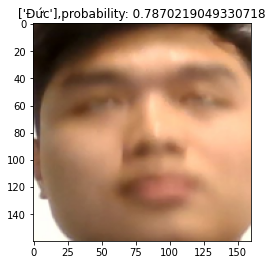

In [ ]:
plt.imshow(x_val[0])
pro = svmClassifier.predict_proba(X_val)[0]
tt = str(le.inverse_transform([y_pred[0]])) + ",probability: " + str(pro[y_pred[0]])
plt.title(tt)
plt.show()

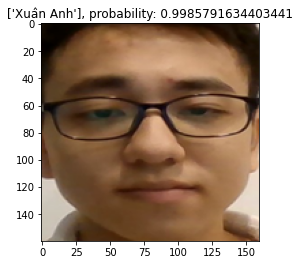

In [ ]:
plt.imshow(x_val[2])
pro = svmClassifier.predict_proba(X_val)[2]
tt = str(le.inverse_transform([y_pred[2]])) + ", probability: " + str(pro[y_pred[2]])
plt.title(tt)
plt.show()

In [ ]:
print(pro)

[3.56687090e-06 7.94327417e-05 5.67497543e-05 2.49492992e-05
 3.04822738e-04 7.23132443e-06 5.04035707e-05 3.89707192e-04
 2.95793685e-04 3.30982168e-05 8.83366161e-05 3.87703592e-05
 9.98579163e-01 4.79741910e-05]


In [ ]:
print(len(detect_error))

271


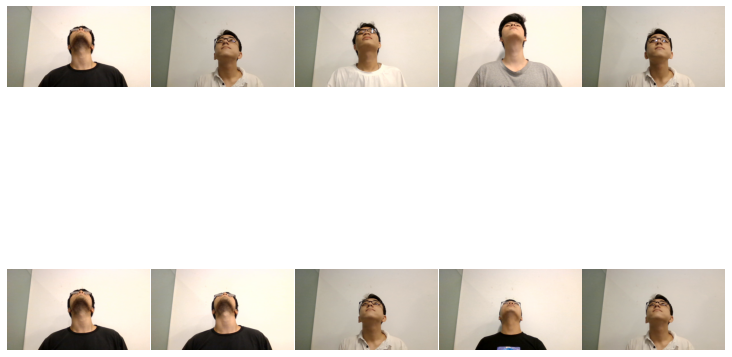

In [ ]:
fig,ax = plt.subplots(2,5,figsize=(10,10))
ax = ax.flatten()
j=0
for i in range(0,271,30):
  ax[j].imshow(detect_error[i])
  ax[j].axis('off')
  j += 1
fig.tight_layout(pad=0.1)

plt.show()